In [1]:
#importing of useful libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, learning_curve, train_test_split, cross_val_score, validation_curve


In [128]:
#load the dataset
df= pd.read_excel('C:/Users/user/.spyder-py3/Python-Machine-Learning-master/Dataset/titanic3 (3).xls')


In [94]:
df.shape

(1309, 14)

<AxesSubplot:>

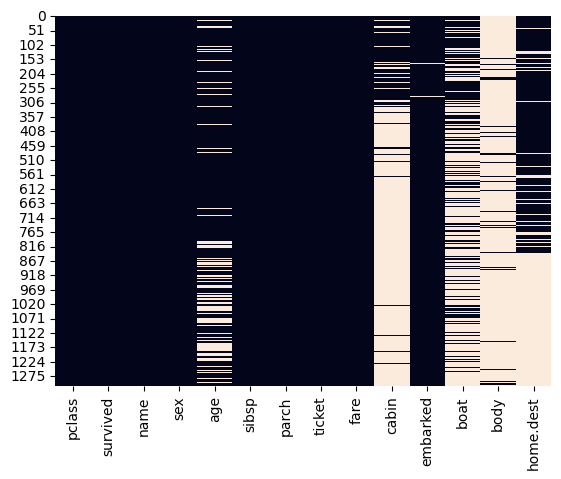

In [95]:
sns.heatmap(df.isna(), cbar=False)

In [96]:
(df.isna().sum()/df.shape[0]).sort_values(ascending= True)

pclass       0.000000
survived     0.000000
name         0.000000
sex          0.000000
sibsp        0.000000
parch        0.000000
ticket       0.000000
fare         0.000764
embarked     0.001528
age          0.200917
home.dest    0.430863
boat         0.628724
cabin        0.774637
body         0.907563
dtype: float64

In [129]:
df= df.drop(['body', 'name', 'ticket', 'home.dest', 'boat', 'cabin'], axis= 1)

In [98]:
df.dtypes

pclass        int64
survived      int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
embarked     object
dtype: object

<AxesSubplot:>

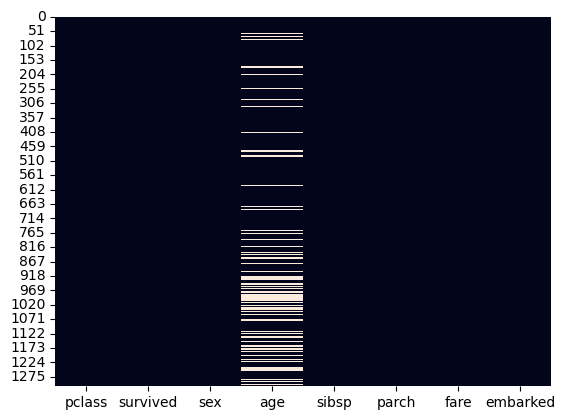

In [99]:
sns.heatmap(df.isna(), cbar=False)

<Figure size 640x480 with 0 Axes>

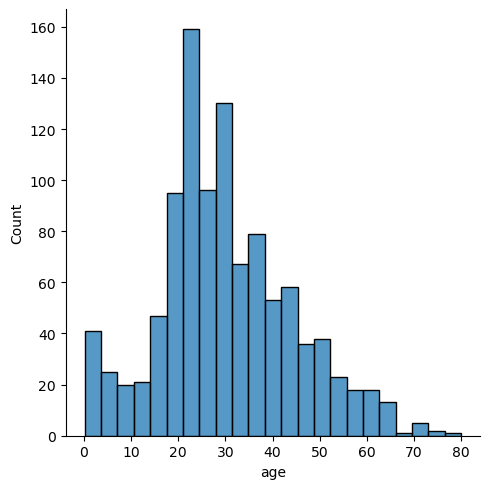

<Figure size 640x480 with 0 Axes>

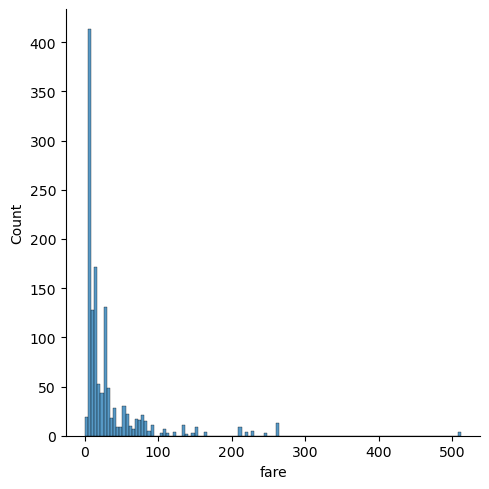

In [100]:
for col in df.select_dtypes('float'):
    plt.figure()
    sns.displot(df[col])


In [101]:
for col in df.select_dtypes('object'):
    print(f'{col:-<50} {df[col].unique()}')

sex----------------------------------------------- ['female' 'male']
embarked------------------------------------------ ['S' 'C' nan 'Q']


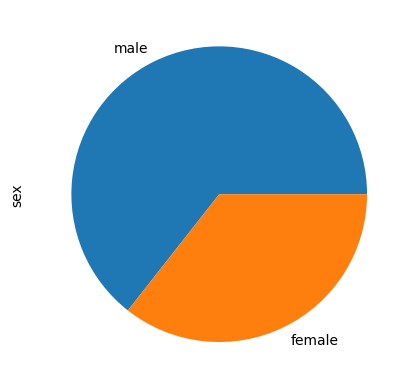

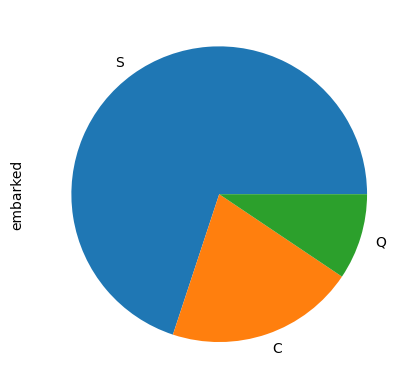

In [102]:
for col in df.select_dtypes('object'):
    plt.figure()
    df[col].value_counts().plot.pie()

In [103]:
survivor= df[df['survived']==1]
no_survivor= df[df['survived']==0]

print(survivor.shape)
print(no_survivor.shape)

(500, 8)
(809, 8)


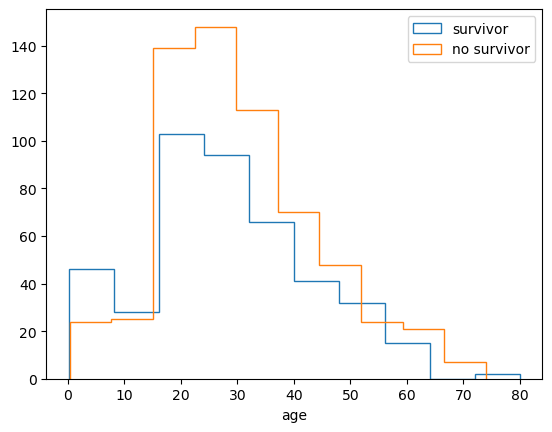

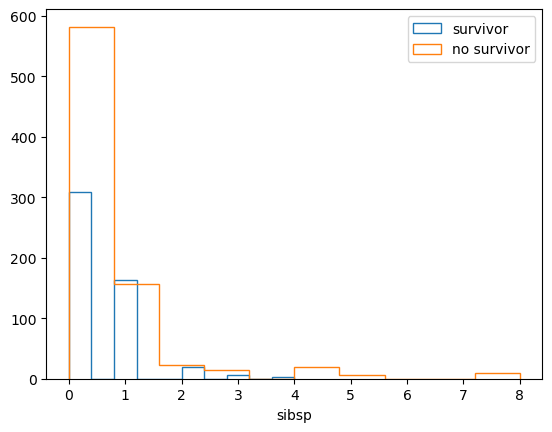

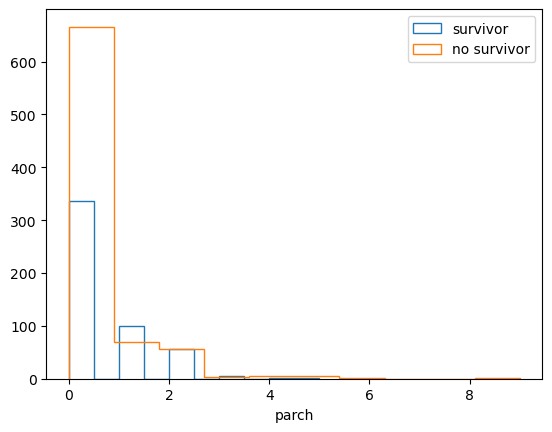

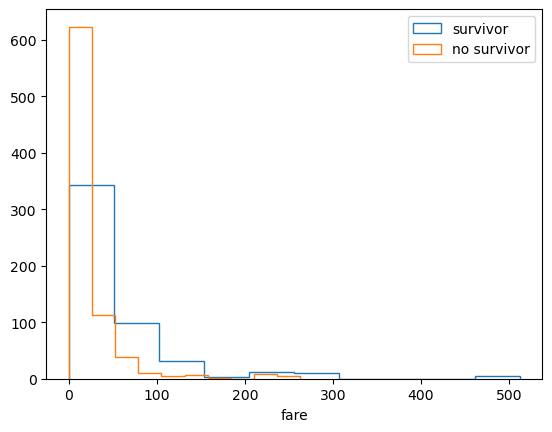

In [104]:
#columns= 

for col in ['age', 'sibsp', 'parch', 'fare' ]:       
    plt.figure()
    plt.hist(survivor[col], label= 'survivor', histtype='step')
    plt.hist(no_survivor[col], label='no survivor', histtype='step')
    plt.xlabel(col)
    plt.legend()

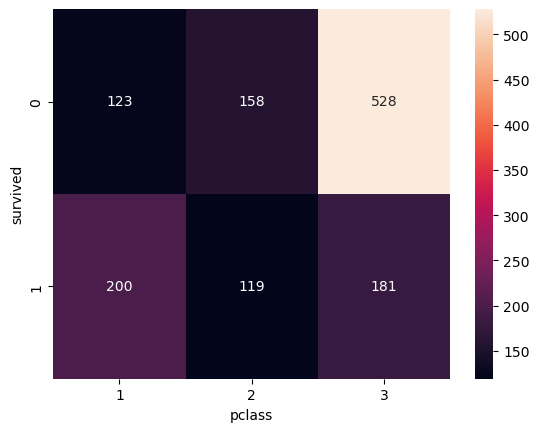

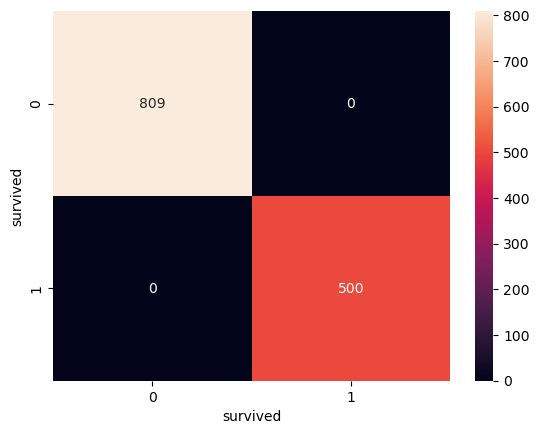

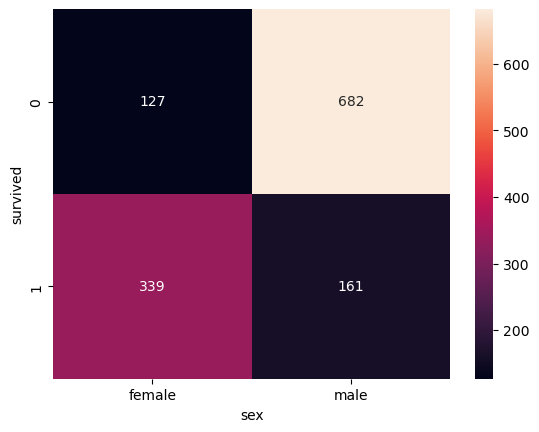

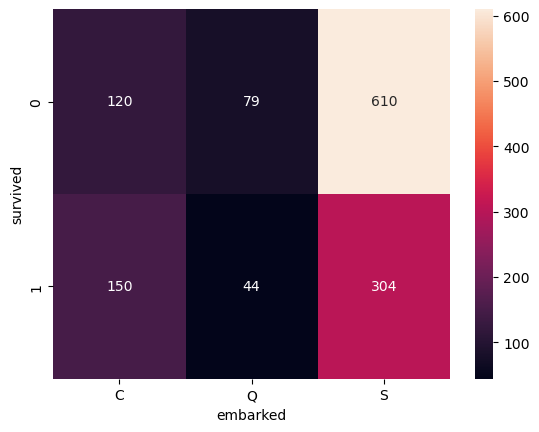

In [105]:
for col in ['pclass', 'survived', 'sex', 'embarked']:
    plt.figure()
    sns.heatmap(pd.crosstab(df['survived'], df[col]), annot= True, fmt='d')

In [130]:
df['is child']= df['age']<=8
df['high fare']= df['fare']>=25
df= df.drop(['age', 'fare'], axis= 1)

df

,pclass,survived,sex,sibsp,parch,embarked,is child,high fare
0,1,1,female,0,0,S,False,True
1,1,1,male,1,2,S,True,True
2,1,0,female,1,2,S,True,True
3,1,0,male,1,2,S,False,True
4,1,0,female,1,2,S,False,True
...,...,...,...,...,...,...,...,...
1304,3,0,female,1,0,C,False,False
1305,3,0,female,1,0,C,False,False
1306,3,0,male,0,0,C,False,False
1307,3,0,male,0,0,C,False,False


In [131]:

code_sex= {'female': 0, 'male': 1}
code_embarked= {'C': 0, 'S': 1, 'Q': 2}

df['sex']= df['sex'].map(code_sex)
df['embarked']= df['embarked'].map(code_embarked)

df

,pclass,survived,sex,sibsp,parch,embarked,is child,high fare
0,1,1,0,0,0,1.0,False,True
1,1,1,1,1,2,1.0,True,True
2,1,0,0,1,2,1.0,True,True
3,1,0,1,1,2,1.0,False,True
4,1,0,0,1,2,1.0,False,True
...,...,...,...,...,...,...,...,...
1304,3,0,0,1,0,0.0,False,False
1305,3,0,0,1,0,0.0,False,False
1306,3,0,1,0,0,0.0,False,False
1307,3,0,1,0,0,0.0,False,False


In [135]:
df= df.dropna(axis=0)
df.isna().sum()

pclass       0
survived     0
sex          0
sibsp        0
parch        0
embarked     0
is child     0
high fare    0
dtype: int64

In [136]:
#split the data set in the train and test set
train_set, test_set= train_test_split(df, test_size= 0.2, random_state=0)

#split the train and test in features and target 
y_train= train_set['survived']
x_train= train_set.drop('survived', axis= 1)
y_test= test_set['survived']
x_test= test_set.drop('survived', axis= 1)


In [147]:
#build an evaluation fonction of model
def evaluation(model, name):
    
    model.fit(x_train, y_train)
    ypred= model.predict(x_test)
    
    print('accuracy score: ', accuracy_score(y_test, ypred))
    
    N, train_score, val_score= learning_curve(model, x_train, y_train, cv= 4, scoring='accuracy',
                                              train_sizes= np.linspace(0.1, 1, 10))
    
    
    plt.figure(figsize= (5, 3))
    plt.plot(N, train_score.mean(axis= 1), label= 'train score')
    plt.plot(N, val_score.mean(axis= 1), label= 'val score')
    plt.xlabel(name)
    plt.legend()

In [163]:
#build pipeline and modelisation
AdaBoost= make_pipeline( PolynomialFeatures(3),
                        AdaBoostClassifier(n_estimators=100, 
                                           random_state= 0))
SVM= make_pipeline( PolynomialFeatures(3), SVC(random_state= 0))
#KNN= make_pipeline( PolynomialFeatures(2, include_bias=False), KNeighborsClassifier())
RandomForest= make_pipeline( PolynomialFeatures(3), RandomForestClassifier(random_state= 0))

models= {'AdaBoost': AdaBoost,
         'SVM': SVM,
         #'KNN': KNN,
         'RandomForest': RandomForest
        }



AdaBoost
accuracy score:  0.8358778625954199
SVM
accuracy score:  0.7251908396946565
RandomForest
accuracy score:  0.8129770992366412


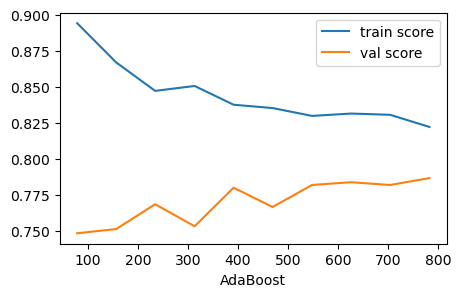

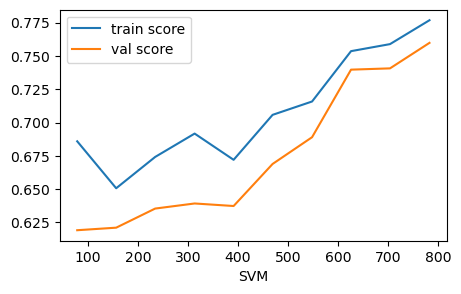

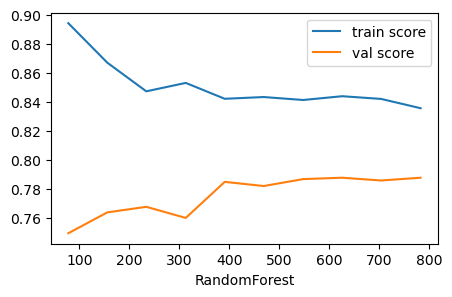

In [151]:
#evaluate different models to find the best
for name, model in models.items():
    print(name)
    evaluation(model, name)

accuracy score:  0.8358778625954199


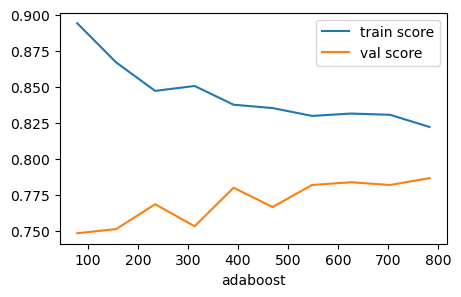

In [165]:
#save the best model and do the final evaluation
evaluation(AdaBoost, 'adaboost')
